In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [248]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

data = pd.read_csv('/content/gdrive/My Drive/capstone2/kakao.csv')
data.head()

,date,close,open,high,low,vol
0,2000-04-10,111500,108000,111500,106000,104221
1,2000-04-11,100000,100500,117000,99500,822622
2,2000-04-12,97000,97000,100000,94000,297372
3,2000-04-14,85400,90000,92000,85400,236537
4,2000-04-17,75200,75200,75200,75200,7533


In [249]:
features = ['close', 'open', 'high', 'low', 'vol']
stockPrice = data[features]
stockPrice.index = data['date']
stockPrice.head()

,close,open,high,low,vol
date,,,,,
2000-04-10,111500,108000,111500,106000,104221
2000-04-11,100000,100500,117000,99500,822622
2000-04-12,97000,97000,100000,94000,297372
2000-04-14,85400,90000,92000,85400,236537
2000-04-17,75200,75200,75200,75200,7533


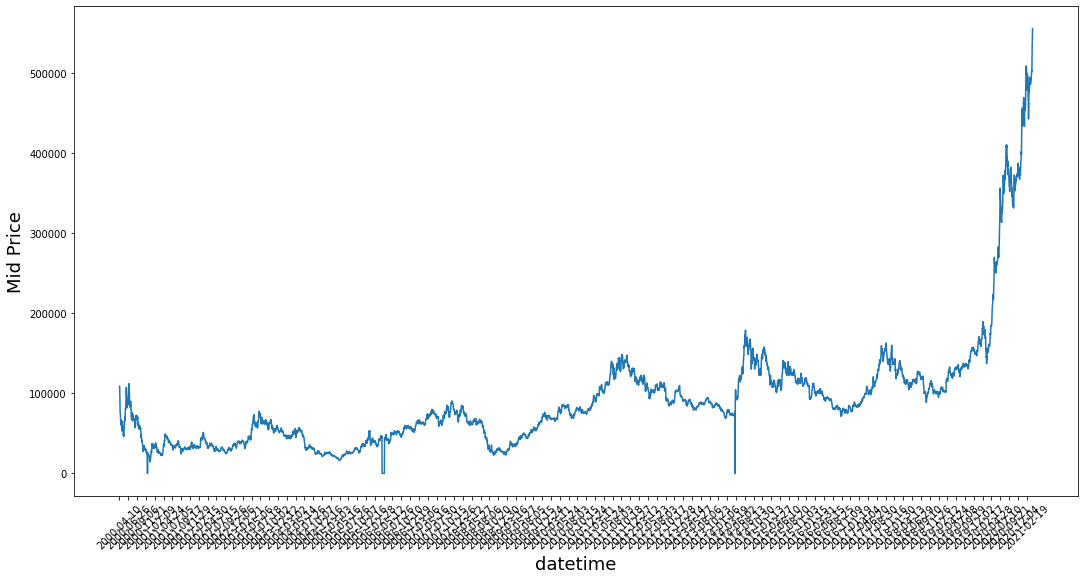

In [250]:
plt.figure(figsize = (18,9))
df = stockPrice.copy()
plt.plot(df.index,(df['low']+df['high'])/2.0)
plt.xticks(df.iloc[::50,:].index,rotation=45)
plt.xlabel('datetime',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

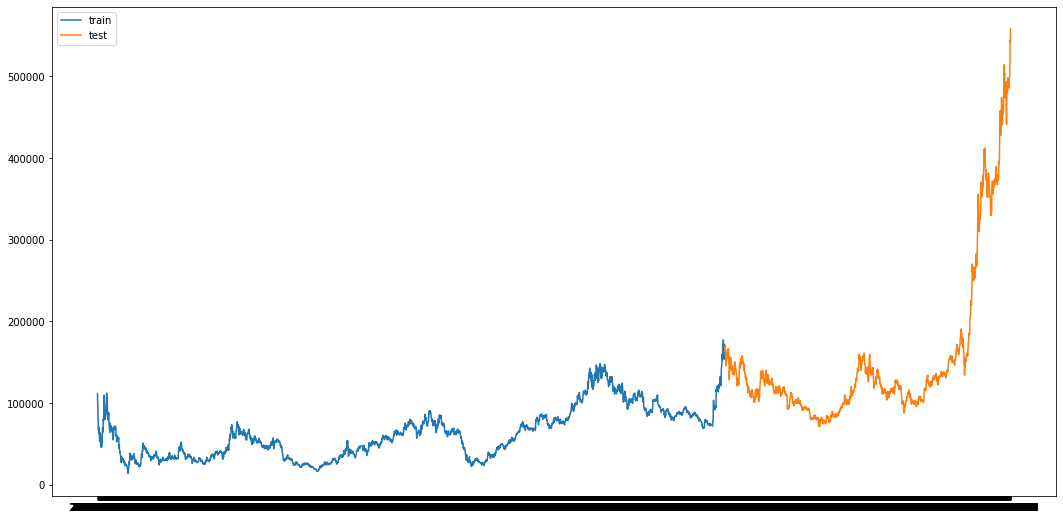

In [251]:
stockPriceClose=stockPrice[['close']]
#학습용 데이터와 테스트용 데이터로 분리
train_data=pd.DataFrame(stockPriceClose.loc[:'2014-09-01',['close']])
test_data=pd.DataFrame(stockPriceClose.loc['2014-09-01':,['close']])
#분리된 데이터 
plt.figure(figsize = (18,9))
plt.plot(train_data)
plt.plot(test_data)
plt.legend(['train', 'test'])
plt.show()

In [252]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() 
train_data_sc=scaler.fit_transform(train_data)
test_data_sc= scaler.transform(test_data)

In [253]:
#학습 데이터와 테스트 데이터( ndarray)를 데이터프레임으로 변형한다.
train_sc_df = pd.DataFrame(train_data_sc, columns=['Scaled'], index=train_data.index)
test_sc_df = pd.DataFrame(test_data_sc, columns=['Scaled'], index=test_data.index)
#LSTM은 과거의 데이터를 기반으로 미래을 예측하는 모델이다. 
#따라서, 과거 데이터를 몇 개 사용해서 예측할 지 정해야 한다. 여기서는 30개(한 달)를 사용한다.  
past_data = 30
for i in range(1, past_data + 1):
    train_sc_df ['Scaled_{}'.format(i)]=train_sc_df ['Scaled'].shift(i)
    test_sc_df ['Scaled_{}'.format(i)]=test_sc_df ['Scaled'].shift(i)

#nan 값이 있는 로우를 삭제하고 X값과 Y값을 생성한다.
x_train=train_sc_df.dropna().drop('Scaled', axis=1)
y_train=train_sc_df.dropna()[['Scaled']]

x_test=test_sc_df.dropna().drop('Scaled', axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

In [254]:
#대부분의 기계학습 모델은 데이터프레임 대신 ndarray구조를 입력 값으로 사용한다.
#ndarray로 변환한다.
x_train=x_train.values
x_test=x_test.values

y_train=y_train.values
y_test=y_test.values

In [261]:
#LSTM 모델에 맞게 데이터 셋 변형
x_train_t = x_train.reshape(x_train.shape[0], past_data,1)
x_test_t = x_test.reshape(x_test.shape[0], past_data, 1)

from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

with tf.device('/device:GPU:0'):
    K.clear_session() 
    # Sequeatial Model
    model = Sequential() 
    # 첫번째 LSTM 레이어
    model.add(LSTM(30,return_sequences=True, input_shape=(past_data, 1))) 
    # 두번째 LSTM 레이어
    model.add(LSTM(42,return_sequences=False))  
    # 예측값 1개
    model.add(Dense(1, activation='linear')) 
    # 손실함수 지정 - 예측 값과 실제 값의 차이를 계산한다. MSE가 사용된다. 
    # 최적화기 지정 - 일반적으로 adam을 사용한다.
    model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 42)                12264     
_________________________________________________________________
dense (Dense)                (None, 1)                 43        
Total params: 16,147
Trainable params: 16,147
Non-trainable params: 0
_________________________________________________________________


In [262]:
#손실 값(loss)를 모니터링해서 성능이 더이상 좋아지지 않으면 epoch를 중단한다.
#vervose=1은 화면에 출력
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

#epochs는 훈련 반복 횟수를 지정하고 batch_size는 한 번 훈련할 때 입력되는 데이터 크기를 지정한다.
model.fit(x_train_t, y_train, epochs=500,
          batch_size=20, verbose=1, callbacks=[early_stop])

y_pred = model.predict(x_test_t)

Epoch 1/500
177/177 [==============================] - 3s 5ms/step - loss: 0.0205
Epoch 2/500
177/177 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 3/500
177/177 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 4/500
177/177 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 5/500
177/177 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 6/500
177/177 [==============================] - 1s 5ms/step - loss: 9.7624e-04
Epoch 7/500
177/177 [==============================] - 1s 5ms/step - loss: 0.0010
Epoch 8/500
177/177 [==============================] - 1s 5ms/step - loss: 8.2457e-04
Epoch 9/500
177/177 [==============================] - 1s 5ms/step - loss: 6.8268e-04
Epoch 10/500
177/177 [==============================] - 1s 5ms/step - loss: 8.4759e-04
Epoch 11/500
177/177 [==============================] - 1s 5ms/step - loss: 7.1951e-04
Epoch 12/500
177/177 [==============================] - 1s 5ms/step - loss: 

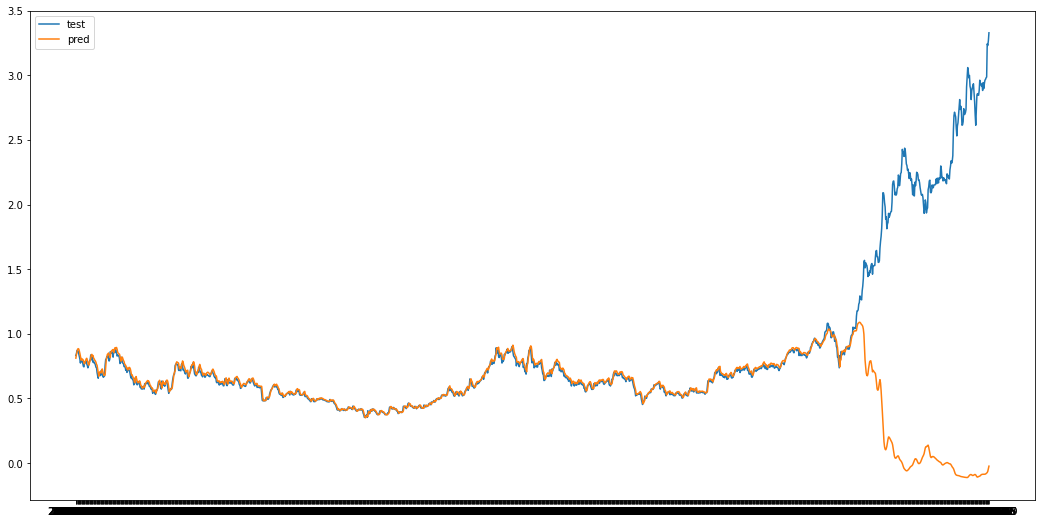

In [263]:
#테스트의 Y값(실측값) 과 예측값을 비교한다.
t_df=test_sc_df.dropna()
y_test_df=pd.DataFrame(y_test, columns=['close'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['close'], index=t_df.index)

plt.figure(figsize = (18,9))
plt.plot(y_test_df)
plt.plot(y_pred_df)
# ax1=y_test_df.plot()
# y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])
plt.show()

In [227]:
# https://post.naver.com/viewer/postView.nhn?volumeNo=29132930&memberNo=18071586